<a href="https://colab.research.google.com/github/Stalinosmj/Malayalam-Transfer-Learning/blob/main/malayalam_transfer_learning_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with malayalam handwritten data

# Import necessary modules

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Dataset direct download

In [2]:
!gdown 'https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a'
!gdown 'https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00'
!gdown 'https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ'

Downloading...
From: https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a
To: /content/Handwritten_V2_train.csv
100% 35.3M/35.3M [00:01<00:00, 22.0MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00
To: /content/Handwritten_V2_valid.csv
100% 11.7M/11.7M [00:00<00:00, 31.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ
To: /content/Handwritten_V2_test.csv
100% 13.0M/13.0M [00:00<00:00, 34.8MB/s]


# Load and view the data

In [3]:
train_data = pd.read_csv("/content/Handwritten_V2_train.csv")
test_data = pd.read_csv("/content/Handwritten_V2_test.csv")
validate_data = pd.read_csv("/content/Handwritten_V2_valid.csv")


# Data description
print("\nStatistical summary of the dataset:")
print(train_data.describe())

# Define the range of samples you want to visualize (e.g., from 1 to 10)
start_index = 101
end_index = 110

# Initialize subplots
fig = sp.make_subplots(rows=2, cols=5, subplot_titles=[f'Sample {i}' for i in range(start_index, end_index+1)])

# Loop through the specified range of samples
for i, sample_index in enumerate(range(start_index, end_index+1)):
    # Select a sample
    pixels = train_data.iloc[sample_index, 1:].values

    # Reshape vector into 32*32 matrix
    image = np.reshape(pixels, (32, 32))

    # Create a Plotly graph
    img_plot = px.imshow(image, color_continuous_scale='gray').data[0]

    # Add trace to the subplots
    fig.add_trace(img_plot, row=(i // 5) + 1, col=(i % 5) + 1)

# Update the layout to hide color scale and set title
fig.update_layout(height=600, width=1000, title_text=f"Sample Images from Train Dataset ({start_index}-{end_index})", showlegend=False)

# Show the figure
fig.show()


Statistical summary of the dataset:
                  1        0      0.1      0.2      0.3           0.4  \
count  17235.000000  17235.0  17235.0  17235.0  17235.0  17235.000000   
mean      42.663127      0.0      0.0      0.0      0.0      0.000058   
std       24.422362      0.0      0.0      0.0      0.0      0.007617   
min        1.000000      0.0      0.0      0.0      0.0      0.000000   
25%       21.000000      0.0      0.0      0.0      0.0      0.000000   
50%       43.000000      0.0      0.0      0.0      0.0      0.000000   
75%       64.000000      0.0      0.0      0.0      0.0      0.000000   
max       85.000000      0.0      0.0      0.0      0.0      1.000000   

                0.5           0.6           0.7           0.8  ...  \
count  17235.000000  17235.000000  17235.000000  17235.000000  ...   
mean       0.000116      0.000174      0.000812      0.001567  ...   
std        0.010772      0.013193      0.028490      0.039550  ...   
min        0.000000      

# Extract labels (first column) and pixels seperatly

In [4]:
# Extract labels and pixel values for each dataset
train_labels = train_data.iloc[:, 0].values
train_pixels = train_data.iloc[:, 1:].values
test_labels = test_data.iloc[:, 0].values
test_pixels = test_data.iloc[:, 1:].values
validate_labels = validate_data.iloc[:, 0].values
validate_pixels = validate_data.iloc[:, 1:].values

# Print unique class labels to verify
print(f'Unique train labels: {np.unique(train_labels)}')
print(f'Unique test labels: {np.unique(test_labels)}')
print(f'Unique validate labels: {np.unique(validate_labels)}')

# Ensure labels start from 0 (adjust if necessary)
train_labels -= train_labels.min()
test_labels -= test_labels.min()
validate_labels -= validate_labels.min()

train_labels -= 1
test_labels -= 1
validate_labels -= 1

# Determine the number of unique classes
num_classes = len(np.unique(train_labels))

Unique train labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]
Unique test labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]
Unique validate labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]


# Reshape and rescale data as per Mobilenetv2 standards

In [5]:
# Reshape pixel values into 32x32 matrices and stack to create 3 channels
train_images = np.concatenate([train_pixels.reshape(-1, 32, 32, 1)] * 3, axis=-1) / 255.0
test_images = np.concatenate([test_pixels.reshape(-1, 32, 32, 1)] * 3, axis=-1) / 255.0
validate_images = np.concatenate([validate_pixels.reshape(-1, 32, 32, 1)] * 3, axis=-1) / 255.0

#  Resize images to 32x32 to match the input size of MobileNetV2

In [6]:
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])
validate_images = tf.image.resize(validate_images, [32, 32])

# Convert labels to categorical using one-hot encoder

In [7]:
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)
validate_labels = tf.keras.utils.to_categorical(validate_labels, num_classes=num_classes)

# Introducing MobileNetV2 model and freeze it for transfer learning

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model
base_model.trainable = False

<ipython-input-8-94c32506f200>:1: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Create a new model on top of base model

In [9]:
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Data augmentation



In [10]:
# Directly fit the model on the training data without data augmentation
model.fit(train_images, train_labels, batch_size=32, epochs=50, validation_data=(validate_images, validate_labels))


Epoch 1/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.0129 - loss: 4.4423 - val_accuracy: 0.0184 - val_loss: 4.4313
Epoch 2/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.0187 - loss: 4.4306 - val_accuracy: 0.0184 - val_loss: 4.4234
Epoch 3/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0185 - loss: 4.4227 - val_accuracy: 0.0184 - val_loss: 4.4160
Epoch 4/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0174 - loss: 4.4169 - val_accuracy: 0.0184 - val_loss: 4.4086
Epoch 5/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0180 - loss: 4.4085 - val_accuracy: 0.0184 - val_loss: 4.4016
Epoch 6/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0193 - loss: 4.4011 - val_accuracy: 0.0203 - val_loss: 4.3944
Epoch 7/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0214 - loss: 4.3941 - val_accuracy: 0.0247 - val_loss: 4.3873
Epoch 8/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0220 - loss: 4.3874 - val_accuracy

# Unfreeze for fine-tuning

In [12]:
# Unfreeze the base model and partially freeze specific layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model without data augmentation
model.fit(train_images, train_labels, batch_size=32, epochs=50, validation_data=(validate_images, validate_labels))


Epoch 1/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.0136 - loss: 7.8823 - val_accuracy: 0.0117 - val_loss: 4.8541
Epoch 2/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0302 - loss: 4.9029 - val_accuracy: 0.0058 - val_loss: 6.1890
Epoch 3/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0575 - loss: 4.4409 - val_accuracy: 0.0102 - val_loss: 4.7282
Epoch 4/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0930 - loss: 4.0918 - val_accuracy: 0.0126 - val_loss: 4.5424
Epoch 5/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1236 - loss: 3.8669 - val_accuracy: 0.0126 - val_loss: 4.5573
Epoch 6/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1577 - loss: 3.5999 - val_accuracy: 0.0126 - val_loss: 4.5838
Epoch 7/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2042 - loss: 3.3613 - val_accuracy: 0.0175 - val_loss: 4.5990
Epoch 8/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2323 - loss: 3.1711 - val_accu

# Evaluate the model

199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6178 - loss: 1.4332
Test loss: 1.640541434288025
Test accuracy: 0.5604654550552368
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


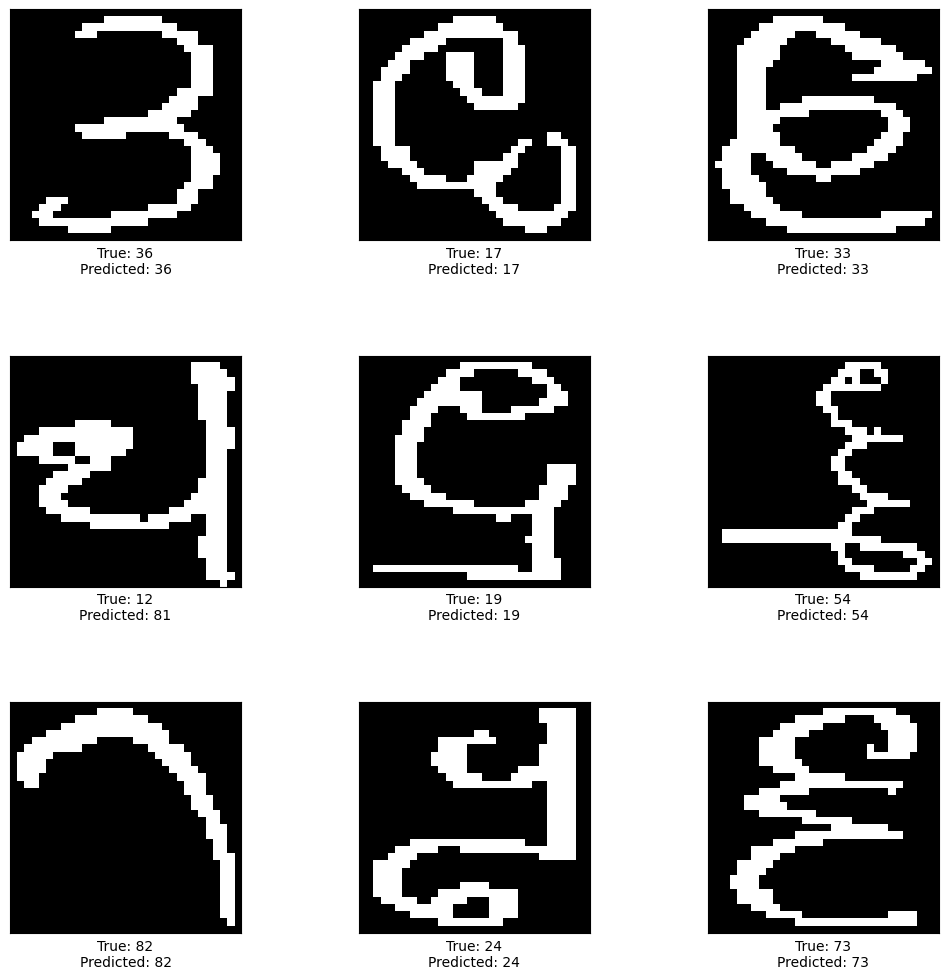

In [13]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

# Predict the values from the test dataset
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

def display_sample(sample_images, sample_labels, sample_predictions):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_images[i].reshape(32, 32), cmap='gray')  # Change to 32x32
        ax.set_xlabel(f"True: {sample_labels[i]}\nPredicted: {sample_predictions[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# Convert images to grayscale for visualization
test_images_gray = np.mean(test_images, axis=-1)

# Selecting a few images from the test set
random_indices = np.random.choice(len(test_images_gray), 9, replace=False)
sample_images = test_images_gray[random_indices]
sample_labels = test_true_classes[random_indices]
sample_predictions = test_predictions_classes[random_indices]

# Display the selected images and their labels
display_sample(sample_images, sample_labels, sample_predictions)

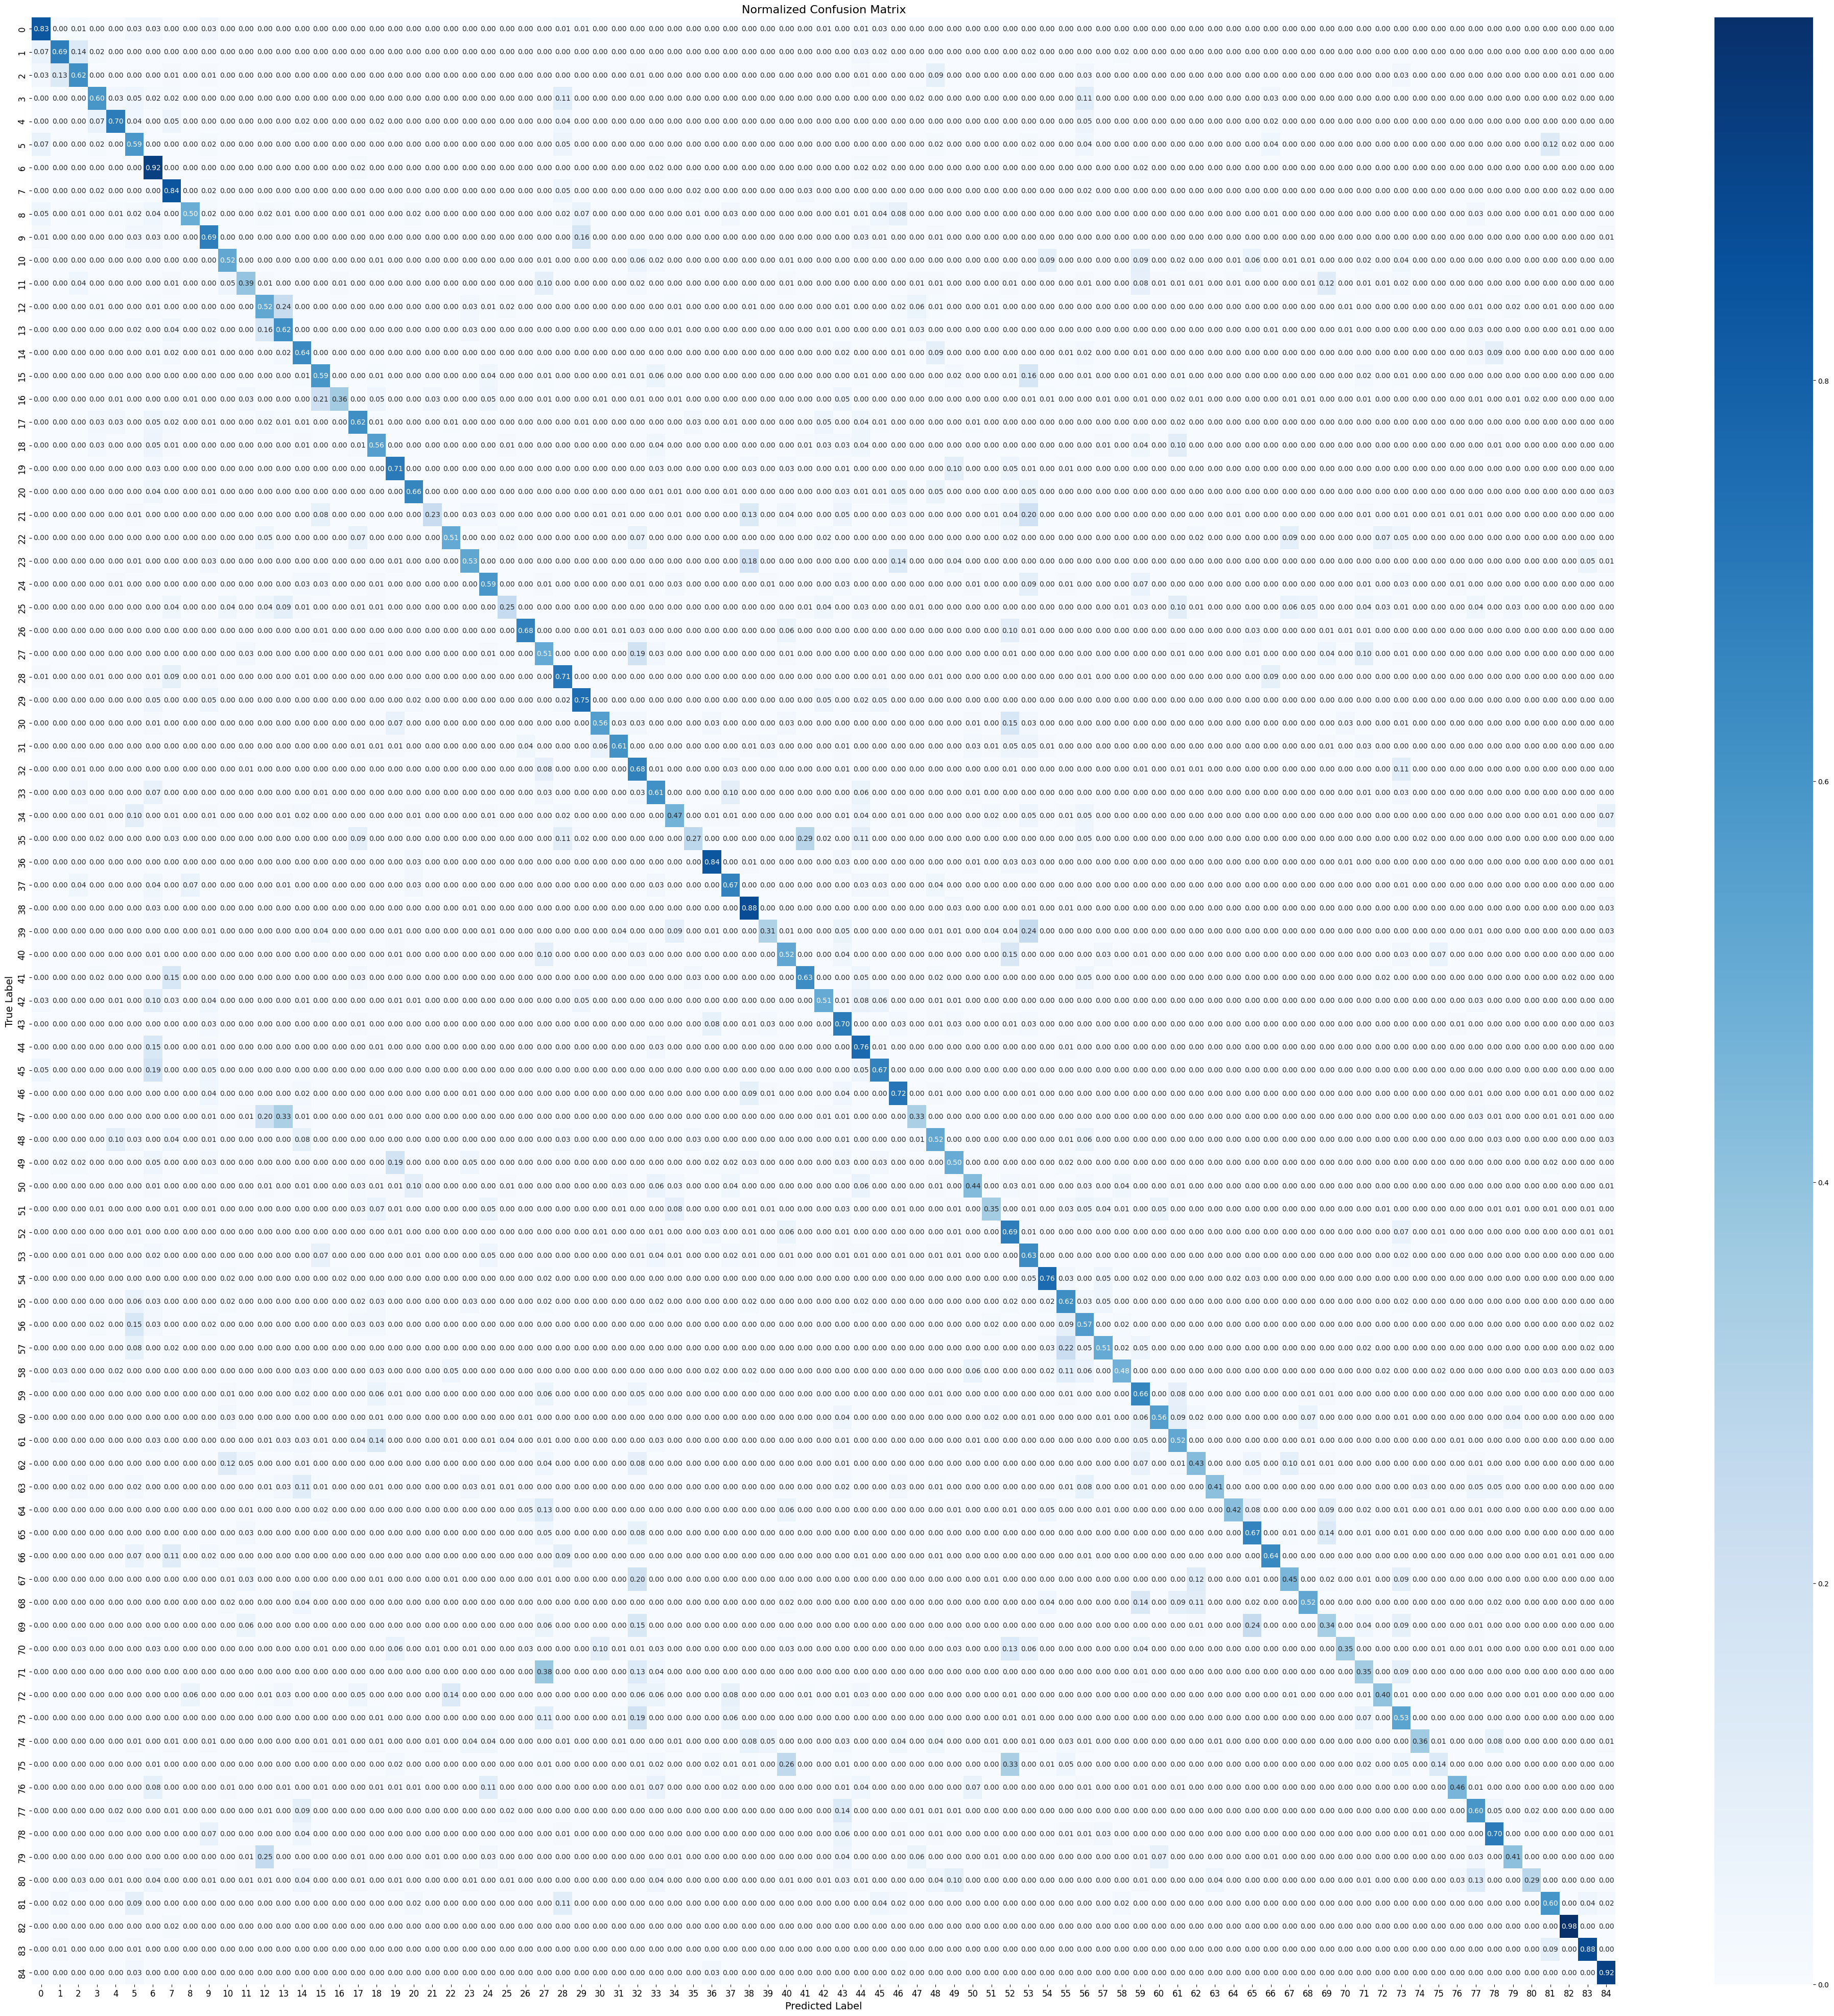

In [14]:
# Compute the confusion matrix
cm = confusion_matrix(test_true_classes, test_predictions_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True, annot_kws={"size": 10})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()